In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [2]:
master_df = pd.read_csv('/home/eunyu/최종 마스터 테이블(8일차)v2.csv')
votes_df = pd.read_csv('/home/eunyu/accounts_userquestionrecord.csv')

master_df.head(3), votes_df.head(3)

(   user_id  total_votes  unique_days  first_vote   last_vote  active_days  \
 0   838023           22            5  2023-04-29  2023-05-04            5   
 1   838466          127            6  2023-05-02  2023-05-07            5   
 2   838642            1            1  2023-04-29  2023-04-29            0   
 
    cohort_day  retention_day8 ret_group ret_group_over ret_group_under gender  \
 0  2023-04-29        0.515152     50 이상          50 이상             NaN      F   
 1  2023-05-02        0.569444     50 이상          50 이상             NaN      F   
 2  2023-04-29        0.515152     50 이상          50 이상             NaN      F   
 
    group_id  school_id  grade  
 0     233.0      271.0    1.0  
 1     321.0      369.0    2.0  
 2     356.0      271.0    2.0  ,
        id status           created_at  chosen_user_id  question_id  user_id  \
 0  771777      C  2023-04-28 12:27:49          849469          252   849436   
 1  771800      C  2023-04-28 12:28:02          849446         

In [3]:
master_df.columns, votes_df.columns

(Index(['user_id', 'total_votes', 'unique_days', 'first_vote', 'last_vote',
        'active_days', 'cohort_day', 'retention_day8', 'ret_group',
        'ret_group_over', 'ret_group_under', 'gender', 'group_id', 'school_id',
        'grade'],
       dtype='object'),
 Index(['id', 'status', 'created_at', 'chosen_user_id', 'question_id',
        'user_id', 'question_piece_id', 'has_read', 'answer_status',
        'answer_updated_at', 'report_count', 'opened_times'],
       dtype='object'))

## 하위지표
### 이성에게 받은 투표 수

In [4]:
# ─── 0-A. 코호트 구분을 min / max 로 재정의 ──────────────────
ret_min = master_df["retention_day8"].min()
ret_max = master_df["retention_day8"].max()

# ↓ retention_day8 이 '최소'인 유저들  → low 그룹
under_df = master_df[master_df["retention_day8"] == ret_min]

# ↓ retention_day8 이 '최대'인 유저들  → high 그룹
over_df  = master_df[master_df["retention_day8"] == ret_max]

# 각 집단의 user_id 집합
low_ids  = set(under_df["user_id"])
high_ids = set(over_df["user_id"])

In [5]:
# 0. 기본 준비
gender_map = master_df[["user_id", "gender"]]
votes = (
    votes_df
      .merge(gender_map, on="user_id", how="left")
      .merge(
          gender_map.rename(columns={"user_id": "chosen_user_id",
                                     "gender":  "chosen_gender"}),
          on="chosen_user_id", how="left")
)

# 1. 전체 통계
def cohort_stats(id_set: set[int]) -> tuple[int, int, float]:
    rcv = votes[votes["chosen_user_id"].isin(id_set)]
    tot = len(rcv)
    opp = len(rcv[rcv["gender"] != rcv["chosen_gender"]])
    return tot, opp, round(opp / tot, 4) if tot else (0, 0, 0.0)

# 2. 성별 세분화
def cohort_gender_stats(ids: set[int], g: str, cohort: pd.DataFrame):
    gender_ids = set(cohort[cohort["gender"] == g]["user_id"])
    return cohort_stats(ids & gender_ids)

# 결과 출력
(high_total, high_opp, high_ratio) = cohort_stats(high_ids)
(low_total,  low_opp,  low_ratio)  = cohort_stats(low_ids)

print(f"[High] 전체 {high_total:,} · 이성 {high_opp:,} · 비율 {high_ratio:.2%}")
print(f"[Low ] 전체 {low_total :,} · 이성 {low_opp :,} · 비율 {low_ratio :.2%}")

h_m_total, h_m_opp, h_m_ratio = cohort_gender_stats(high_ids, "M", over_df)
h_f_total, h_f_opp, h_f_ratio = cohort_gender_stats(high_ids, "F", over_df)
l_m_total, l_m_opp, l_m_ratio = cohort_gender_stats(low_ids,  "M", under_df)
l_f_total, l_f_opp, l_f_ratio = cohort_gender_stats(low_ids,  "F", under_df)

print(f"High-M  비율 {h_m_ratio:.2%} | High-F  비율 {h_f_ratio:.2%}")
print(f"Low-M   비율 {l_m_ratio:.2%} | Low-F   비율 {l_f_ratio:.2%}")

[High] 전체 76,994 · 이성 20,813 · 비율 27.03%
[Low ] 전체 20,414 · 이성 4,822 · 비율 23.62%
High-M  비율 32.52% | High-F  비율 23.34%
Low-M   비율 25.54% | Low-F   비율 21.71%


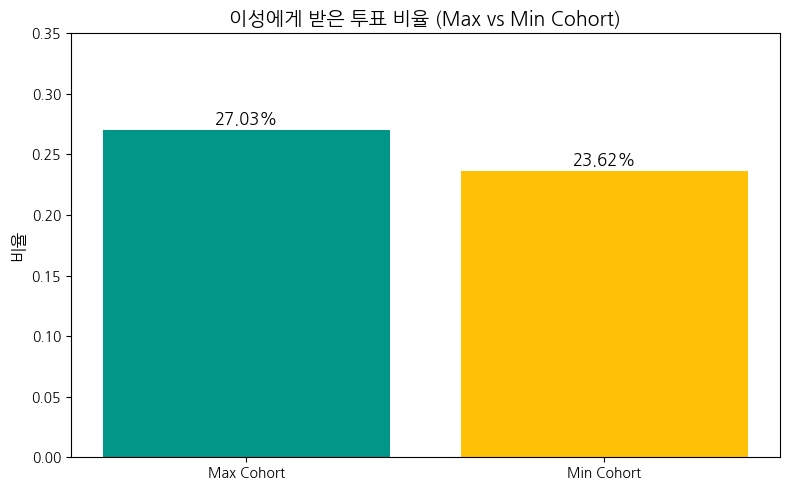

In [7]:


# ─── min/max 코호트 기준 비율 시각화 ─────────────────────────
labels = ['Max Cohort', 'Min Cohort']  # 기준 명칭 변경
ratios = [0.2703, 0.2362]              # min/max 기준 비율
colors = ['#009688', '#ffc107']        # 색상은 유지

# 막대 그래프
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, ratios, color=colors)
for bar, ratio in zip(bars, ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{ratio:.2%}", ha='center', fontsize=12)

plt.ylim(0, 0.35)
plt.title("이성에게 받은 투표 비율 (Max vs Min Cohort)", fontsize=14)
plt.ylabel("비율", fontsize=12)
plt.tight_layout()
plt.show()


In [8]:

# ───────────────────────────────────────────────
# 1. 성별 정보가 포함된 votes_with_gender 생성
#   - master_df : user_id, gender  포함
#   - votes_df  : user_id(투표자), chosen_user_id(피투표자) 포함
# ───────────────────────────────────────────────
gender_map = master_df[['user_id', 'gender']]

votes_with_gender = (
    votes_df
      .merge(gender_map,                           on='user_id',      how='left')  # 투표자 성별 → gender
      .merge(gender_map.rename(
             columns={'user_id': 'chosen_user_id',
                      'gender':  'chosen_gender'}),
             on='chosen_user_id',                 how='left')         # 피투표자 성별 → chosen_gender
)

# ───────────────────────────────────────────────
# 2. 성별·코호트별 유저 집합
# ───────────────────────────────────────────────
high_male_ids   = over_df.loc[over_df['gender']=='M', 'user_id']
high_female_ids = over_df.loc[over_df['gender']=='F', 'user_id']
low_male_ids    = under_df.loc[under_df['gender']=='M', 'user_id']
low_female_ids  = under_df.loc[under_df['gender']=='F', 'user_id']

# ───────────────────────────────────────────────
# 3. 집합별 이성에게 받은 투표만 필터
# ───────────────────────────────────────────────
def opposite_votes(df, id_series):
    return df[
        (df['chosen_user_id'].isin(id_series)) &
        (df['gender'] != df['chosen_gender'])
    ]

high_male_received   = opposite_votes(votes_with_gender, high_male_ids)
high_female_received = opposite_votes(votes_with_gender, high_female_ids)
low_male_received    = opposite_votes(votes_with_gender, low_male_ids)
low_female_received  = opposite_votes(votes_with_gender, low_female_ids)

# ───────────────────────────────────────────────
# 4. 유저당 평균 이성 투표 수 계산
# ───────────────────────────────────────────────
avg_high_male   = len(high_male_received)   / len(high_male_ids)
avg_high_female = len(high_female_received) / len(high_female_ids)
avg_low_male    = len(low_male_received)    / len(low_male_ids)
avg_low_female  = len(low_female_received)  / len(low_female_ids)

summary = {
    "Max Cohort": {
        "남자 유저 수": len(high_male_ids),
        "여자 유저 수": len(high_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_high_male,   2),
        "여자 유저당 평균 이성 투표 수": round(avg_high_female, 2)
    },
    "Min Cohort": {
        "남자 유저 수": len(low_male_ids),
        "여자 유저 수": len(low_female_ids),
        "남자 유저당 평균 이성 투표 수": round(avg_low_male,    2),
        "여자 유저당 평균 이성 투표 수": round(avg_low_female,  2)
    }
}


summary


{'Max Cohort': {'남자 유저 수': 89,
  '여자 유저 수': 142,
  '남자 유저당 평균 이성 투표 수': 113.18,
  '여자 유저당 평균 이성 투표 수': 75.63},
 'Min Cohort': {'남자 유저 수': 57,
  '여자 유저 수': 62,
  '남자 유저당 평균 이성 투표 수': 45.61,
  '여자 유저당 평균 이성 투표 수': 35.84}}